In [3]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
import numpy as np
%matplotlib inline

In [4]:
usecols = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']
urls = ['https://www.football-data.co.uk/mmz4281/{}{}/F1.csv'.format(i,i+1) for i in range(15, 20)]

In [5]:
def load_data_clean(urls, usecols, date_format = '%d%m%y'):
    # load data
    df = pd.concat((pd.read_csv(url, usecols=usecols) for url in urls), ignore_index=True).dropna()
    # create the Date
    date_converter = lambda x: ''.join([x.replace('/20', '').replace('/', '')[i:i+2] for i in range(0, len(x.replace('/20', '').replace('/', '')), 2)])
    df['Date'] = pd.to_datetime(df.Date.apply(date_converter), format=date_format)
    df['HomeTeam'], team_unique = df.HomeTeam.factorize()
    df['AwayTeam'] = df.AwayTeam.apply(lambda x: list(team_unique).index(x))
    return df, list(team_unique)

In [6]:
df, teams = load_data_clean(urls, usecols)

In [7]:
import difflib
calendar = pd.read_csv('../data/calendrier_l1.csv', index_col=None).drop(columns=['Unnamed: 0', 'score', 'url'])
pat = '(AS|Olympique|SCO|Stade|FC|RC)'
calendar.team1 = calendar.team1.str.replace(pat, '').apply(lambda x: difflib.get_close_matches(x, teams, cutoff=0.1, n=1)[0] if x != 'LOSC' else 'Lille').apply(lambda x: teams.index(x))
calendar.team2 = calendar.team2.str.replace(pat, '').apply(lambda x: difflib.get_close_matches(x, teams, cutoff=0.1, n=1)[0] if x != 'LOSC' else 'Lille').apply(lambda x: teams.index(x))

## Column explanation

|Column|Meaning|
|--|--|
|FTHG|Full Time Home Team Goals|
|FTAG|Full Time Away Team Goals|
|FTR |Full Time Result|
|HTHG|Half Time Home Team Goals|
|HTAG|Half Time Away Team Goals|
|HTR |Half Time Result|
|HS|Home Team Shots|
|AS|Away Team Shots|
|HST|Home Team Shots on Target|
|AST|Away Team Shots on Target|
|HF|Home Team Fouls Committed|
|AF|Away Team Fouls Committed|
|HC|Home Team Corners|
|AC|Away Team Corners|
|HY|Home Team Yellow Cards|
|AY|Away Team Yellow Cards|
|HR|Home Team Red Cards|
|AR|Away Team Red Cards|

## DATA PREP

In [8]:
def trfrm_dat(df, var):
    df[var] = np.where(df['Team'] == df['HomeTeam'],
                                     df['H{}'.format(var)],
                                     df['A{}'.format(var)])
    df['{}_Opp'.format(var)] = np.where(df['Team'] != df['HomeTeam'],
                                     df['H{}'.format(var)],
                                     df['A{}'.format(var)])
    return df 

def data_by_team(df, k = 5):
    # copy dataset to avoid to write on;
    df_copy = df.copy(); 
    
    # unpivot data
    df_copy['H'] = df_copy['HomeTeam']
    df_copy['A'] = df_copy['AwayTeam']
    cols_to_keep = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 
                    'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']

    team_results = pd.melt(
        df_copy, 
        id_vars=cols_to_keep, 
        value_vars=['H', 'A'],
        var_name='Home/Away',
        value_name='Team')
    
    team_results['Opponent'] = np.where(team_results['Team'] == team_results['HomeTeam'],
                                        team_results['AwayTeam'],
                                        team_results['HomeTeam'])

    team_results['FTG'] = np.where(team_results['Team'] == team_results['HomeTeam'],
                                     team_results['FTHG'],
                                     team_results['FTAG'])
    team_results['FTG_Opp'] = np.where(team_results['Team'] != team_results['HomeTeam'],
                                         team_results['FTHG'],
                                         team_results['FTAG'])
    
    col = ['S', 'ST', 'F', 'C', 'Y', 'R']
    for var in col:    
        trfrm_dat(team_results, var)
        
    team_results['final_result'] = team_results.apply(lambda x: 'D' if x['FTR'] == 'D' else 'W' if x['Home/Away'] == x['FTR'] else 'L', axis=1)
    
    col_todrop = ['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']
    team_results.drop(columns=col_todrop, inplace=True)
    df_copy2 = team_results.copy()
    
    # create new variables
    col_to_shift = list(df_copy2.columns[4:])
    for sort_by in ['Team', 'Opponent']:
        df_copy2 = df_copy2.sort_values(by=[sort_by, 'Date'])
        for var in col_to_shift:
            for i in range(1, k+1):
                df_copy2['{}_{}_{}'.format(var, sort_by, i)] = df_copy2.groupby([sort_by])[var].shift(i)
                
    df_copy2['Year'] = df_copy2['Date'].apply(lambda x: x.year)
    df_copy2['Month'] = df_copy2['Date'].apply(lambda x: x.month)
    
    f = lambda x: tuple(sum([1 if x is r else 0 for x in list(x)])/len(x) for r in ['W', 'D', 'L'])

    to_m = df_copy2.groupby(['Team', 'Year']).final_result.apply(f).apply(pd.Series, index=["scoret_w", "scoret_d", "scoret_l"]).reset_index()

    df_3 = pd.merge(right=pd.merge(right=df_copy2, left=to_m, left_on=['Team', 'Year'], right_on=['Team', 'Year']), 
                    left=to_m, left_on=['Team', 'Year'], right_on=['Opponent', 'Year'])
    
    data = df_3[['Date', 'Home/Away', 'Team_y', 'Opponent', 'final_result', 
             "scoret_w_x", "scoret_d_x", "scoret_l_x", 
             "scoret_w_y", "scoret_d_y", "scoret_l_y"]+list(df_copy2.columns[19:])]

    return data

In [9]:
data = data_by_team(df)

In [11]:
len(data.columns)

163

## Transform

In [96]:
def transform_data(data):
    data = data.dropna()
    # Features + target 
    X = data.drop(columns='final_result')
    y = data.final_result
    # transform
    X_obj = X.select_dtypes('object').apply(lambda x: x.factorize()[0], axis=0)
    X_con = X[['Year', 'Month']+list(X.select_dtypes('float').columns)]
    #pca = PCA(n_components=30, random_state=0)
    #X_con = pca.fit_transform(X_con)
    X = pd.concat([X_obj, X_con], axis=1)
    return X, y

In [97]:
X, y = transform_data(data)

## Training

In [98]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [99]:
import itertools as it
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


In [100]:
def train(X, y, model=None, param_grid=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    pipe = Pipeline([('model', model)])
    search = GridSearchCV(pipe, param_grid, iid=True, cv=5, n_jobs=-1)
    search.fit(X_train, y_train)
    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)
    return search

In [101]:
rf = RandomForestClassifier(class_weight='balanced',random_state=1)
param_grid = {
    'model__n_estimators':[77, 80, ],
    'model__max_depth':[5, 7],
    'model__min_samples_leaf':[6, 7]
}
model = train(X, y, model=rf, param_grid=param_grid)

Best parameter (CV score=0.521):
{'model__max_depth': 7, 'model__min_samples_leaf': 6, 'model__n_estimators': 80}


In [48]:
cm = confusion_matrix(y_test, model.predict(X_test))
[cm[i,i]/cm[:,i].sum() for i in range(3)]

NameError: name 'y_test' is not defined

In [54]:
cm

array([[ 83,  65,  61],
       [ 69, 148,  71],
       [ 67,  53, 166]], dtype=int64)

In [102]:
proba = model.predict_proba(X)

In [103]:
rslt_df = pd.DataFrame({
    'Date': data.Date[X.index],
    'Team': data.Team_y[X.index],
    'Opponent': data.Opponent[X.index],
    'Win':proba[:,2],
    'Drawback':proba[:,0],
    'Lose':proba[:,1]
})

In [104]:
# Data
def plot_bar_proba(one_rslt_df, team):
    r = [i for i in range(one_rslt_df.shape[0])]

    # From raw value to percentage
    totals = [i+j+k for i,j,k in zip(one_rslt_df['Win'], one_rslt_df['Drawback'], one_rslt_df['Lose'])]
    greenBars = [i / j * 100 for i,j in zip(one_rslt_df['Win'], totals)]
    orangeBars = [i / j * 100 for i,j in zip(one_rslt_df['Drawback'], totals)]
    blueBars = [i / j * 100 for i,j in zip(one_rslt_df['Lose'], totals)]

    # plot
    barWidth = 0.85
    names = tuple(one_rslt_df.iloc[:,3])
    # Create green Bars
    plt.barh(r, greenBars, color='#b5ffb9', edgecolor='white', height=barWidth)
    # Create orange Bars
    plt.barh(r, orangeBars, left=greenBars, color='#f9bc86', edgecolor='white', height=barWidth)
    # Create blue Bars
    plt.barh(r, blueBars, left=[i+j for i,j in zip(greenBars, orangeBars)], color='#a3acff', edgecolor='white', height=barWidth)

    # Custom x axis
    plt.yticks(r, names)
    plt.ylabel("group")
    plt.title('Team' + ' = ' + team)
    
    # Show graphic
    plt.show()

In [22]:
team = 5
r = 0
one_rslt_df = rslt_df[rslt_df['Team'] == team].drop(columns='Team').sort_values('Date', ascending=False)
one_rslt_df['Date'] = one_rslt_df.Date.astype('str')
one_rslt_df['Date and Team'] = one_rslt_df['Date'] + ' - ' + one_rslt_df['Opponent'].apply(lambda x: teams[x])
one_rslt_df = one_rslt_df.iloc[:5].drop(columns=['Date', 'Opponent'])

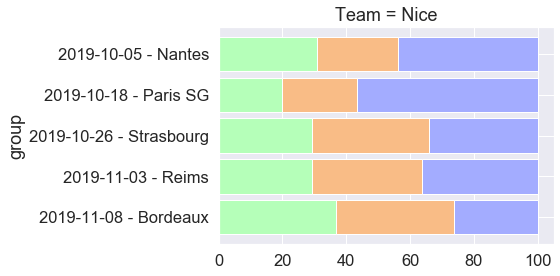

In [23]:
plot_bar_proba(one_rslt_df, teams[team])

## Model interpreation

## Prediction new data

In [105]:
def paria_prediction(team, opponent, day, month, year, model=None):
    # input: Team, Opponent, Date
    team = teams.index('Dijon')
    Opponent = teams.index('Rennes')
    Date = datetime(2019, 11, 23)

    match_to_predict = {'Date': Date, 'HomeTeam': team, 'AwayTeam': Opponent, 'FTHG': np.NaN, 'FTAG': np.NaN, 
     'FTR': np.NaN, 'HTHG': np.NaN, 'HTAG': np.NaN, 'HTR': np.NaN, 'HS': np.NaN, 'AS': np.NaN, 
     'HST': np.NaN, 'AST': np.NaN, 'HF': np.NaN, 'AF': np.NaN, 'HC': np.NaN, 'AC': np.NaN, 
     'HY': np.NaN, 'AY': np.NaN, 'HR': np.NaN, 'AR': np.NaN}

    row_pred = pd.DataFrame(match_to_predict, index=[0])
    pred_data = data_by_team(pd.concat([df, row_pred]))
    x = pred_data.sort_values('Date').iloc[-2:]
    X2pred, _ = transform_data(x)
    prediction = model.predict_proba(X2pred)
    # difference lose one vs win other
    proba_pari = (prediction[:,0].mean(), # drawback
     sum((prediction[0,1], prediction[1,2]))/2, # lose first and win second
     sum((prediction[0,2], prediction[1,1]))/2) # win first and lose second
    return proba_pari

In [277]:
def paria_prediction(day, model=None):
    cal = calendar.iloc[np.where(calendar.day == day)[0]]
    date = datetime.today()
    match_to_predict = {'Date': [date for _ in range(len(cal))], 'HomeTeam': cal.team1, 'AwayTeam': cal.team2, 'FTHG': np.NaN, 'FTAG': np.NaN, 
         'FTR': np.NaN, 'HTHG': np.NaN, 'HTAG': np.NaN, 'HTR': np.NaN, 'HS': np.NaN, 'AS': np.NaN, 
         'HST': np.NaN, 'AST': np.NaN, 'HF': np.NaN, 'AF': np.NaN, 'HC': np.NaN, 'AC': np.NaN, 
         'HY': np.NaN, 'AY': np.NaN, 'HR': np.NaN, 'AR': np.NaN}
    row_pred = pd.DataFrame(match_to_predict)
    pred_data = data_by_team(pd.concat([df, row_pred]))
    x = pred_data.sort_values('Date')[-20:]
    X2pred, _ = transform_data(x)
    prediction = model.predict_proba(X2pred)
    # create dataframe for prediction
    df_pred = pd.DataFrame(prediction, columns=['Drawback', 'Lose', 'Win'])
    df_pred[['Team', 'Opponent']] = x[['Team_y','Opponent']].reset_index(drop=True).applymap(lambda x: teams[x])
    df_pred['Home/Away'] = x['Home/Away'].reset_index(drop=True)
    df_pred['index_match'] = df_pred[['Team', 'Opponent']].apply(lambda x: str(sorted(x)), axis=1).factorize()[0]
    df_pred['Home'] = df_pred.apply(lambda x: x.Win if x['Home/Away'] is 'H' else x.Lose, axis=1)
    df_pred['Away'] = df_pred.apply(lambda x: x.Win if x['Home/Away'] is 'A' else x.Lose, axis=1)
    df_pred['HomeTeam'] = df_pred.apply(lambda x: x.Team if x['Home/Away'] is 'H' else x.Opponent, axis=1)
    df_pred['AwayTeam'] = df_pred.apply(lambda x: x.Team if x['Home/Away'] is 'A' else x.Opponent, axis=1)
    df4predict = df_pred.groupby(['HomeTeam', 'AwayTeam'])[['Home', 'Drawback', 'Away']].mean()
    return df4predict

In [278]:
paria_prediction(14, model)

,,Home,Drawback,Away
HomeTeam,AwayTeam,,,
Amiens,Strasbourg,0.291440,0.398902,0.309658
Angers,Nimes,0.407738,0.351943,0.240319
Bordeaux,Monaco,0.319368,0.334147,0.346486
Brest,Nantes,0.393502,0.338712,0.267785
Dijon,Rennes,0.265604,0.340328,0.394068
Lyon,Nice,0.427514,0.306696,0.265789
Metz,Reims,0.283744,0.407366,0.308890
Paris SG,Lille,0.530266,0.219306,0.250428
St Etienne,Montpellier,0.394179,0.338067,0.267754


In [460]:
# input: Team, Opponent, Date
team = teams.index('Dijon')
Opponent = teams.index('Rennes')
Date = datetime(2019, 11, 23)

match_to_predict = {'Date': Date, 'HomeTeam': team, 'AwayTeam': Opponent, 'FTHG': np.NaN, 'FTAG': np.NaN, 
 'FTR': np.NaN, 'HTHG': np.NaN, 'HTAG': np.NaN, 'HTR': np.NaN, 'HS': np.NaN, 'AS': np.NaN, 
 'HST': np.NaN, 'AST': np.NaN, 'HF': np.NaN, 'AF': np.NaN, 'HC': np.NaN, 'AC': np.NaN, 
 'HY': np.NaN, 'AY': np.NaN, 'HR': np.NaN, 'AR': np.NaN}

row_pred = pd.DataFrame(match_to_predict, index=[0])
pred_data = data_by_team(pd.concat([df, row_pred]))
x = pred_data.sort_values('Date').iloc[-2:]
X2pred, _ = transform_data(x)
prediction = search.predict_proba(X2pred)
# difference lose one vs win other
team_pari = ' - '.join([teams[i] for i in list(x.Team_y)])
proba_pari = (prediction[:,0].mean(), # drawback
 sum((prediction[0,1], prediction[1,2]))/2, # lose first and win second
 sum((prediction[0,2], prediction[1,1]))/2) # win first and lose second
print('{0}:\nHome -> {3}\nDrawback -> {1}\nAway -> {2}'.format(team_pari, *proba_pari))

Rennes - Dijon:
Home -> 0.3941015071066388
Drawback -> 0.33493682997535124
Away -> 0.27096166291801005
Wall time: 1.83 s


## module paria

In [9]:
usecols = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']
urls = ['https://www.football-data.co.uk/mmz4281/{}{}/F1.csv'.format(i,i+1) for i in range(15, 20)]
rf = RandomForestClassifier(class_weight='balanced',random_state=1)
param_grid = {
    'model__n_estimators':[77, 80, ],
    'model__max_depth':[5, 7],
    'model__min_samples_leaf':[6, 7]
}

In [10]:
df, teams = load_data_clean(urls, usecols)

In [63]:
class Paria():
    
    def __init__(self,  df, teams, model, param):
        self.model, self.param = model, param
        self.df, self.teams = df, teams
        self.model = self.train(*self.transform_data(self.data_by_team(self.df)), self.model, self.param)

    def trfrm_dat(self, df, var):
        df[var] = np.where(df['Team'] == df['HomeTeam'],
                                         df['H{}'.format(var)],
                                         df['A{}'.format(var)])
        df['{}_Opp'.format(var)] = np.where(df['Team'] != df['HomeTeam'],
                                         df['H{}'.format(var)],
                                         df['A{}'.format(var)])
        return df 

    def data_by_team(self, df, k = 5):
        # copy dataset to avoid to write on;
        df_copy = df.copy(); 

        # unpivot data
        df_copy['H'] = df_copy['HomeTeam']
        df_copy['A'] = df_copy['AwayTeam']
        cols_to_keep = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']

        team_results = pd.melt(df_copy, id_vars=cols_to_keep, value_vars=['H', 'A'], var_name='Home/Away', value_name='Team')

        team_results['Opponent'] = np.where(team_results['Team'] == team_results['HomeTeam'], team_results['AwayTeam'], team_results['HomeTeam'])
        team_results['FTG'] = np.where(team_results['Team'] == team_results['HomeTeam'], team_results['FTHG'],team_results['FTAG'])
        team_results['FTG_Opp'] = np.where(team_results['Team'] != team_results['HomeTeam'], team_results['FTHG'], team_results['FTAG'])

        col = ['S', 'ST', 'F', 'C', 'Y', 'R']
        for var in col:    
            self.trfrm_dat(team_results, var)

        team_results['final_result'] = team_results.apply(lambda x: 'D' if x['FTR'] == 'D' else 'W' if x['Home/Away'] == x['FTR'] else 'L', axis=1)

        col_todrop = ['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']
        team_results.drop(columns=col_todrop, inplace=True)
        df_copy2 = team_results.copy()

        # create new variables
        col_to_shift = list(df_copy2.columns[4:])
        for sort_by in ['Team', 'Opponent']:
            df_copy2 = df_copy2.sort_values(by=[sort_by, 'Date'])
            for var in col_to_shift:
                for i in range(1, k+1):
                    df_copy2['{}_{}_{}'.format(var, sort_by, i)] = df_copy2.groupby([sort_by])[var].shift(i)

        # month, year
        df_copy2['Year'] = df_copy2['Date'].apply(lambda x: x.year)
        df_copy2['Month'] = df_copy2['Date'].apply(lambda x: x.month)

        # mean target
        f = lambda x: tuple(sum([1 if x is r else 0 for x in list(x)])/len(x) for r in ['W', 'D', 'L'])
        to_m = df_copy2.groupby(['Team', 'Year']).final_result.apply(f).apply(pd.Series, index=["scoret_w", "scoret_d", "scoret_l"]).reset_index()
        df_3 = pd.merge(right=pd.merge(right=df_copy2, left=to_m, left_on=['Team', 'Year'], right_on=['Team', 'Year']), 
                        left=to_m, left_on=['Team', 'Year'], right_on=['Opponent', 'Year'])

        data = df_3[['Date', 'Home/Away', 'Team_y', 'Opponent', 'final_result', "scoret_w_x", "scoret_d_x", "scoret_l_x", "scoret_w_y", "scoret_d_y", "scoret_l_y"]+list(df_copy2.columns[19:])].dropna()

        return data
    
    def transform_data(self, data):
        # Features + target 
        X = data.drop(columns='final_result')
        y = data.final_result
        # transform
        X_obj = X.select_dtypes('object').apply(lambda x: x.factorize()[0], axis=0)
        X_con = X[['Year', 'Month']+list(X.select_dtypes('float').columns)]
        #pca = PCA(n_components=30, random_state=0)
        #X_con = pca.fit_transform(X_con)
        X = pd.concat([X_obj, X_con], axis=1)
        return X, y
    
    def train(self, X, y, model=None, param_grid=None):
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
        pipe = Pipeline([('model', model)])
        search = GridSearchCV(pipe, param_grid, iid=True, cv=5, n_jobs=-1)
        search.fit(X_train, y_train)
        print("Best parameter (CV score=%0.3f):" % search.best_score_)
        print(search.best_params_)
        return search
    
    def paria_prediction(self, team, opponent, day, month, year):
        # input: Team, Opponent, Date
        team = self.teams.index(team)
        Opponent = self.teams.index(opponent)
        Date = datetime(year, month, day)

        match_to_predict = {'Date': Date, 'HomeTeam': team, 'AwayTeam': Opponent, 'FTHG': np.NaN, 'FTAG': np.NaN, 
         'FTR': np.NaN, 'HTHG': np.NaN, 'HTAG': np.NaN, 'HTR': np.NaN, 'HS': np.NaN, 'AS': np.NaN, 
         'HST': np.NaN, 'AST': np.NaN, 'HF': np.NaN, 'AF': np.NaN, 'HC': np.NaN, 'AC': np.NaN, 
         'HY': np.NaN, 'AY': np.NaN, 'HR': np.NaN, 'AR': np.NaN}

        row_pred = pd.DataFrame(match_to_predict, index=[0])
        pred_data = self.data_by_team(pd.concat([self.df, row_pred]))
        x = pred_data.sort_values('Date').iloc[-2:]
        X2pred, _ = self.transform_data(x)
        prediction = self.model.predict_proba(X2pred)
        team_pari = tuple(teams[i] for i in list(x.Team_y))
        # difference lose one vs win other
        proba_pari = (prediction[:,0].mean(), # drawback
         sum((prediction[0,1], prediction[1,2]))/2, # lose first and win second
         sum((prediction[0,2], prediction[1,1]))/2) # win first and lose second
        print('{0} -> {4}\nDrawback -> {2}\n{1} -> {3}'.format(*team_pari, *proba_pari))

In [64]:
paria = Paria(df, teams, rf, param_grid)

Best parameter (CV score=0.521):
{'model__max_depth': 7, 'model__min_samples_leaf': 6, 'model__n_estimators': 80}


In [72]:
paria.paria_prediction('Paris SG', 'Lille', 24, 11, 2019)

Paris SG -> 0.4781401023537245
Drawback -> 0.23382263085415
Lille -> 0.2880372667921257


In [1]:
from utils_data.data_prep import load_data_clean, data_preparation, creation_features, transform_data
from utils_data.train import train
from sklearn.ensemble import RandomForestClassifier
from utils_data.prediction import paria_prediction

usecols = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']
urls = ['https://www.football-data.co.uk/mmz4281/{}{}/F1.csv'.format(i,i+1) for i in range(15, 20)]

df, teams = load_data_clean(urls, usecols)
X, y = transform_data(creation_features(data_preparation(df)))
rf = RandomForestClassifier(class_weight='balanced',random_state=1)
param_grid = {
    'model__n_estimators':[77, 80, ],
    'model__max_depth':[5, 7],
    'model__min_samples_leaf':[6, 7]
}
model = train(X, y, model=rf, param_grid=param_grid)

# prediction
paria_prediction('Toulouse', 'Marseille', 22, 11, 2019, teams, df, model)

In [6]:
import pickle

In [7]:
pickle.dump(model, open('model/rf.pkl', 'wb'))